In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import numpy as np

import os
import argparse

from IPython import display
import PIL
from PIL import ImageFilter

import cv2
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# from models import *
# from utils import progress_bar


# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
# parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
# parser.add_argument('--resume', '-r', action='store_true',
#                     help='resume from checkpoint')
# args = parser.parse_args()





In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='d:/mldata/cifar', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='d:/mldata/cifar', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Root(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1):
        super(Root, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size,
            stride=1, padding=(kernel_size - 1) // 2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, xs):
        x = torch.cat(xs, 1)
        out = F.relu(self.bn(self.conv(x)))
        return out


class Tree(nn.Module):
    def __init__(self, block, in_channels, out_channels, level=1, stride=1):
        super(Tree, self).__init__()
        self.root = Root(2*out_channels, out_channels)
        if level == 1:
            self.left_tree = block(in_channels, out_channels, stride=stride)
            self.right_tree = block(out_channels, out_channels, stride=1)
        else:
            self.left_tree = Tree(block, in_channels,
                                  out_channels, level=level-1, stride=stride)
            self.right_tree = Tree(block, out_channels,
                                   out_channels, level=level-1, stride=1)

    def forward(self, x):
        out1 = self.left_tree(x)
        out2 = self.right_tree(out1)
        out = self.root([out1, out2])
        return out


class SimpleDLA(nn.Module):
    def __init__(self, block=BasicBlock, num_classes=10):
        super(SimpleDLA, self).__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        self.layer3 = Tree(block,  32,  64, level=1, stride=1)
        self.layer4 = Tree(block,  64, 128, level=2, stride=2)
        self.layer5 = Tree(block, 128, 256, level=2, stride=2)
        self.layer6 = Tree(block, 256, 512, level=1, stride=2)
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def test():
    net = SimpleDLA()
    # print(net)
    x = torch.randn(1, 3, 128, 128)
    y = net(x)
    print(y.size())


if __name__ == '__main__':
    test()

torch.Size([1, 10])


In [4]:


classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
# net = VGG('VGG19')
# net = ResNet18()
# net = PreActResNet18()
# net = GoogLeNet()
# net = DenseNet121()
# net = ResNeXt29_2x64d()
# net = MobileNet()
# net = MobileNetV2()
# net = DPN92()
# net = ShuffleNetG2()
# net = SENet18()
# net = ShuffleNetV2(1)
# net = EfficientNetB0()
# net = RegNetX_200MF()
net = SimpleDLA()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

# if args.resume:
# Load checkpoint.
print('==> Resuming from checkpoint..')
assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
checkpoint = torch.load('checkpoint/ckpt.pth')
net.load_state_dict(checkpoint['net'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

print(start_epoch)
print(checkpoint['epoch'])

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train(epoch):    
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        display.clear_output(True)
        print( 'Loss: %.3f | Acc: %.3f%% (%d/%d)' % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        # progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #              % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            display.clear_output(True)
            print( 'Loss: %.3f | Acc: %.3f%% (%d/%d)' % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            # progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, 'checkpoint/ckpt.pth')
        best_acc = acc


==> Building model..
==> Resuming from checkpoint..
341
341


In [5]:
# for epoch in range(start_epoch, start_epoch+150):
#     train(epoch)
#     test(epoch)
#     scheduler.step()

In [6]:
# state = {
#             'net': net.state_dict(),
#             'acc': best_acc,
#             'epoch': epoch,
#         }
# torch.save(state, 'checkpoint/ckpt2.pth')

In [7]:
# state = {
#             'net': net.state_dict(),
#             'acc': best_acc,
#             'epoch': epoch,
#         }
# torch.save(state, 'checkpoint/ckpt.pth')

In [8]:
# checkpoint = torch.load('checkpoint/ckpt.pth')
# net.load_state_dict(checkpoint['net'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 32, 32)
Label: airplane , Predicted: airplane


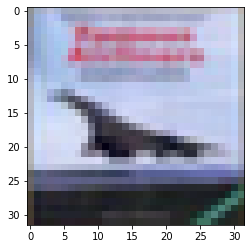

In [9]:
net.eval()
im = testset[3][0]
print(im.numpy().shape)
im = im.numpy().transpose(1, 2, 0)
normalizedimage = cv2.normalize(im,None, 0, 1, cv2.NORM_MINMAX)
img, label = testset[3]
# print(testset[3])
plt.imshow(normalizedimage)

def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return trainset.classes[preds[0].item()]

print('Label:', trainset.classes[label], ', Predicted:', predict_image(img, net))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


frog
frog


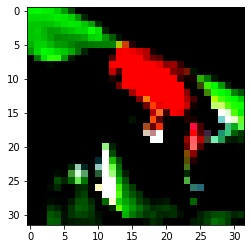

In [10]:

img = cv2.imread('inputimage/frog2.png')
img = cv2.imread('inputimage/frog1.jpg')
# img = cv2.imread('inputimage/horse1.jpg')
# img = cv2.imread('inputimage/deer1.jpg')
# img = cv2.imread('inputimage/frog3.png')
# img = cv2.imread('inputimage/auto1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# cv2.imshow('s', img)
# cv2.waitKey(0) # waits until a key is pressed
# cv2.destroyAllWindows() # destroys the window showing image
img = torch.FloatTensor(img)
img = img/255
# print(img.permute(2, 0, 1).shape)
plt.imshow(img)

transform_norm = transforms.Compose([    
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
  
# get normalized image
img_normalized = transform_norm(img.permute(2, 0, 1))

plt.imshow(img_normalized.permute(1, 2, 0))

print(predict_image(img_normalized, net))
print(predict_image(img.permute(2, 0, 1), net))

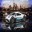

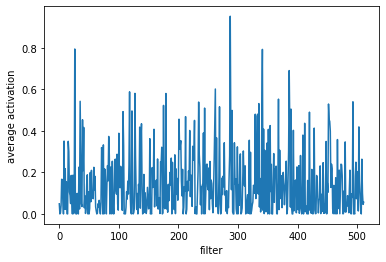

In [30]:

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def preprocess_image(image):
    image = (image - mean) / std
    image = np.expand_dims(image, axis=0).transpose(0,3,1,2)
    return torch.Tensor(image)

def deprocess_image(tensor):
    tensor = ((tensor * std) + mean)
    tensor = np.uint8(tensor * 255.0)
    return PIL.Image.fromarray(tensor)

class ActivationsExtractor():
    
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output):
        self.features = output

# print(list(net.children())[0].layer6)
layer = list(net.children())[0].layer6 # last non-output layer

activations = ActivationsExtractor(layer) # activations' hook


TEST_IMAGE = PIL.Image.open("inputimage/auto1.jpg")
display.display(TEST_IMAGE)
preprocessed_image = preprocess_image(np.asarray(TEST_IMAGE)/255.0)
_ = net(preprocessed_image.cuda()) # forward pass to collect activations

average_activations_per_filters = [activations.features[0, i].mean().item() for i in range(activations.features.shape[1])]

fig = plt.plot(average_activations_per_filters)
ax = fig[0].axes
ax.set_xlabel("filter")
ax.set_ylabel("average activation")
plt.show()

In [27]:
most_activated_filter_idx = np.argmax(average_activations_per_filters)
print(most_activated_filter_idx)

394


In [28]:
def visualize(lr, steps, size, upscales, upscale_factor):
    img = np.uint8(np.random.uniform(0, 1, (size, size, 3)))
    
    for _ in range(upscales):
        
        img_var = preprocess_image(img).clone().detach().cuda().requires_grad_(True)
        optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
        print(img_var.shape)
        for _ in range(steps):
            optimizer.zero_grad()
            
            net(img_var)
            loss = -activations.features[0, most_activated_filter_idx].mean()
            loss.backward()
            optimizer.step()

        img = deprocess_image(img_var.data.cpu().numpy()[0].transpose(1,2,0))
        display.display(img)

        size = int(upscale_factor * size) 
        img = img.resize((size, size)) 
        img = img.filter(ImageFilter.BLUR)
        img = np.asarray(img) / 255.0

torch.Size([1, 3, 28, 28])


torch.Size([1, 3, 42, 42])


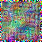

torch.Size([1, 3, 63, 63])


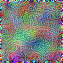

torch.Size([1, 3, 94, 94])


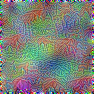

torch.Size([1, 3, 141, 141])


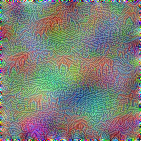

torch.Size([1, 3, 211, 211])


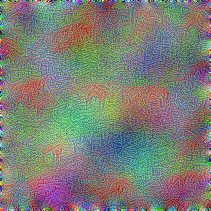

torch.Size([1, 3, 316, 316])


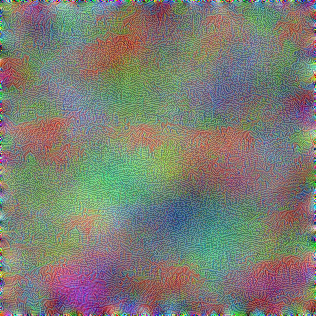

torch.Size([1, 3, 474, 474])


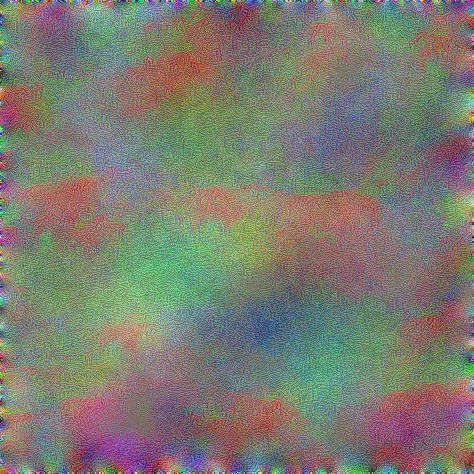

In [29]:
visualize(lr=0.075,
          size=28,
          steps=15,
          upscales=8,
          upscale_factor=1.5)